In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', family='Malgun Gothic',size=8, weight = 'bold')

In [2]:
#1. 데이터 가져오기
파일 = pd.ExcelFile('C:\ETF\portfolio_monthly_data.xlsx')
자산군 = 파일.sheet_names
print (자산군)

['국가', '채권', '현금', '섹터', '팩터']


In [3]:
#2. 자산군별 데이터 프레임 설정

자료 = {}
for i in 자산군:
    자료[i] = 파일.parse(i)
    자료[i].index = 자료[i].Date
    #날짜 있는 컬럼을 삭제함.
    자료[i].drop('Date', axis = 1, inplace=True)
    #날짜 컬럼을 제외한 컬럼의 갯수
    print(i+'개수',len(자료[i].columns))

국가개수 7
채권개수 5
현금개수 1
섹터개수 15
팩터개수 8


In [4]:
자료['현금'].columns

Index(['KODEX단기채권'], dtype='object')

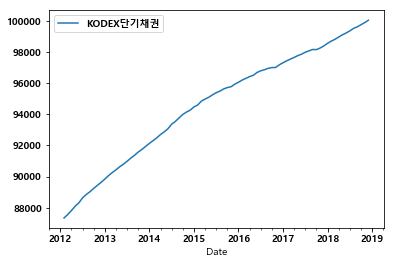

In [5]:
자료["현금"].plot()

In [6]:
자료['현금'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 1 columns):
KODEX단기채권    83 non-null int64
dtypes: int64(1)
memory usage: 1.3 KB


In [7]:
자료['팩터'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 8 columns):
TIGER로우볼       83 non-null int64
TIGER2차전지테마    83 non-null int64
KBSTAR고배당      83 non-null int64
TIGER대형가치      83 non-null int64
TIGER우량가치      83 non-null int64
TIGER여행레저      83 non-null int64
KOSEF블루칩       83 non-null int64
KODEX200중소형    83 non-null int64
dtypes: int64(8)
memory usage: 5.8 KB


In [8]:
자료['섹터'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 15 columns):
KODEXIT          83 non-null int64
KODEX건설          83 non-null int64
TIGER미디어컨텐츠      83 non-null int64
TIGER헬스케어        83 non-null int64
TIGER화장품         83 non-null int64
TIGER은행          83 non-null int64
KODEX기계장비        83 non-null int64
KODEX바이오         83 non-null int64
KODEX반도체         83 non-null int64
KODEX증권          83 non-null int64
KODEX자동차         83 non-null int64
TIGER미디어컨텐츠.1    83 non-null int64
TIGER200에너지화학    83 non-null int64
TIGER200철강소재     83 non-null int64
KODEX보험          83 non-null int64
dtypes: int64(15)
memory usage: 10.4 KB


In [9]:
자료["국가"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 7 columns):
KODEX200              83 non-null int64
KODEX코스닥150           83 non-null int64
KODEX미국S&P500선물(H)    83 non-null int64
KODEX일본TOPIX100       83 non-null int64
TIGER유로스탁스50(합성 H)    83 non-null int64
KODEX중국본토 A50         83 non-null int64
KINDEX베트남VN30(합성)     83 non-null int64
dtypes: int64(7)
memory usage: 5.2 KB


In [10]:
자료["채권"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 5 columns):
KOSEF국고채10년    83 non-null int64
KODEX국고채3년     83 non-null int64
KOSEF미국달러선물    83 non-null int64
TIGER일본엔선물     83 non-null int64
KODEX단기채권      83 non-null int64
dtypes: int64(5)
memory usage: 3.9 KB


In [11]:
#3. 함수 설정

def 월간수익률(데이터):
    #월별 수익률 = 금월 데이터/전월 데이터
    return 데이터 / 데이터.shift(1)

def 변동성대비모멘텀(데이터):
    a = 데이터/데이터.shift(12)
    b = 월간수익률(데이터).rolling(12).std()
    return a/b

def 연평균수익률(데이터):
    return 데이터/데이터.shift(12)

def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

In [12]:
def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

In [13]:
def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

In [14]:
def 평균모멘텀스코어6(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 7):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/6
    return a

In [15]:
# 현금 비중 지정, 보수적(1), 보통(0.5), 공격적(0.25)
def 현금혼합모멘텀수익곡선(데이터, 현금비율=0.25):
    x = 월간수익률(자료['현금'])*현금비율
    y = 월간수익률(데이터)*평균모멘텀스코어(데이터).shift(1)
    a = pd.DataFrame((y.values+x.values)/(현금비율+평균모멘텀스코어(데이터).shift(1).values)).cumprod() 
    a.index = 데이터.index
    a.columns = 데이터.columns
    return a

def 자산군통합포트(데이터, 순위, 자산군비중):
    x = 월간수익률(현금혼합모멘텀수익곡선(데이터))
    y = np.where(모멘텀순위(데이터, 순위).shift(1)==0,np.nan,자산군비중/순위)
    print ("모멘텀순위 : ",데이터.columns,"중에서",모멘텀순위(데이터, 순위).columns[3])
    z = ((x*y).sum(1)).dropna()
    z = z.replace(0, np.nan)
    return z

#자산군별 모멘텀 랭킹 상위 종목 개수 선정
def 통합모멘텀(국가비중,섹터비중,팩터비중,채권비중):
    a = 자산군통합포트(자료['국가'],4,국가비중)  #자산군통합포트(자료,상위종목수,비중)
    b = 자산군통합포트(자료['섹터'],8,섹터비중)
    c = 자산군통합포트(자료['팩터'],1,팩터비중)
    d = 자산군통합포트(자료['채권'],1,채권비중)
    e = (pd.concat([a, b, c, d], axis=1).sum(1)/(국가비중+섹터비중+팩터비중+채권비중))
    e = e.replace(0,np.nan).cumprod()
    e.columns = ['통합수익']
    return e

In [16]:
#4. 결과 plot

# 현금의 월간 수익률 구하기
x = 월간수익률(자료['현금'])
국가비중 = 1 ; 섹터비중 = 1 ; 팩터비중 = 1 ; 채권비중 = 3
# 전략의 통합모멘텀 구하기
# 인덱스는 현금의 인덱스로 업데이트한다. 이것은 raw데이타의 인덱스 일치해야 함을 뜻한다
y = pd.DataFrame(통합모멘텀(국가비중,섹터비중,팩터비중,채권비중), index = x.index)

모멘텀순위 :  Index(['KODEX200', 'KODEX코스닥150', 'KODEX미국S&P500선물(H)', 'KODEX일본TOPIX100',
       'TIGER유로스탁스50(합성 H)', 'KODEX중국본토 A50', 'KINDEX베트남VN30(합성)'],
      dtype='object') 중에서 KODEX일본TOPIX100
모멘텀순위 :  Index(['KODEXIT', 'KODEX건설', 'TIGER미디어컨텐츠', 'TIGER헬스케어', 'TIGER화장품', 'TIGER은행',
       'KODEX기계장비', 'KODEX바이오', 'KODEX반도체', 'KODEX증권', 'KODEX자동차',
       'TIGER미디어컨텐츠.1', 'TIGER200에너지화학', 'TIGER200철강소재', 'KODEX보험'],
      dtype='object') 중에서 TIGER헬스케어
모멘텀순위 :  Index(['TIGER로우볼', 'TIGER2차전지테마', 'KBSTAR고배당', 'TIGER대형가치', 'TIGER우량가치',
       'TIGER여행레저', 'KOSEF블루칩', 'KODEX200중소형'],
      dtype='object') 중에서 TIGER대형가치
모멘텀순위 :  Index(['KOSEF국고채10년', 'KODEX국고채3년', 'KOSEF미국달러선물', 'TIGER일본엔선물', 'KODEX단기채권'], dtype='object') 중에서 TIGER일본엔선물


In [17]:
# 전략의 6개월 모멘텀, 월간수익률구하기
a = pd.DataFrame((월간수익률(y).values*평균모멘텀스코어6(y).shift(1).values+(1-평균모멘텀스코어6(y).shift(1).values)*x.values), index = x.index).cumprod().dropna()

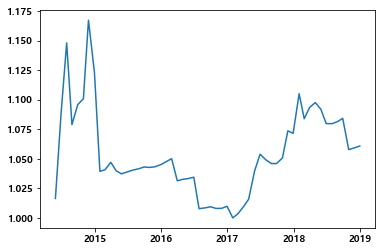

In [18]:
plt.plot(a)
plt.show()

In [19]:
b = 자료['국가'].KODEX200/자료['국가'].KODEX200.iloc[0]

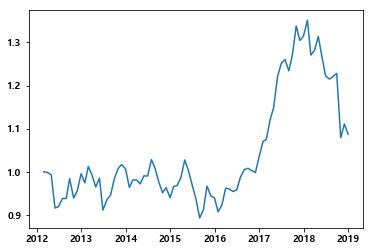

In [20]:
plt.plot(b)

In [21]:
c = pd.concat([a, b], axis=1).dropna()

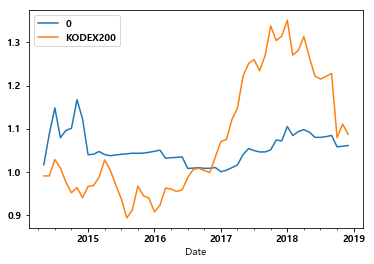

In [22]:
c.plot()

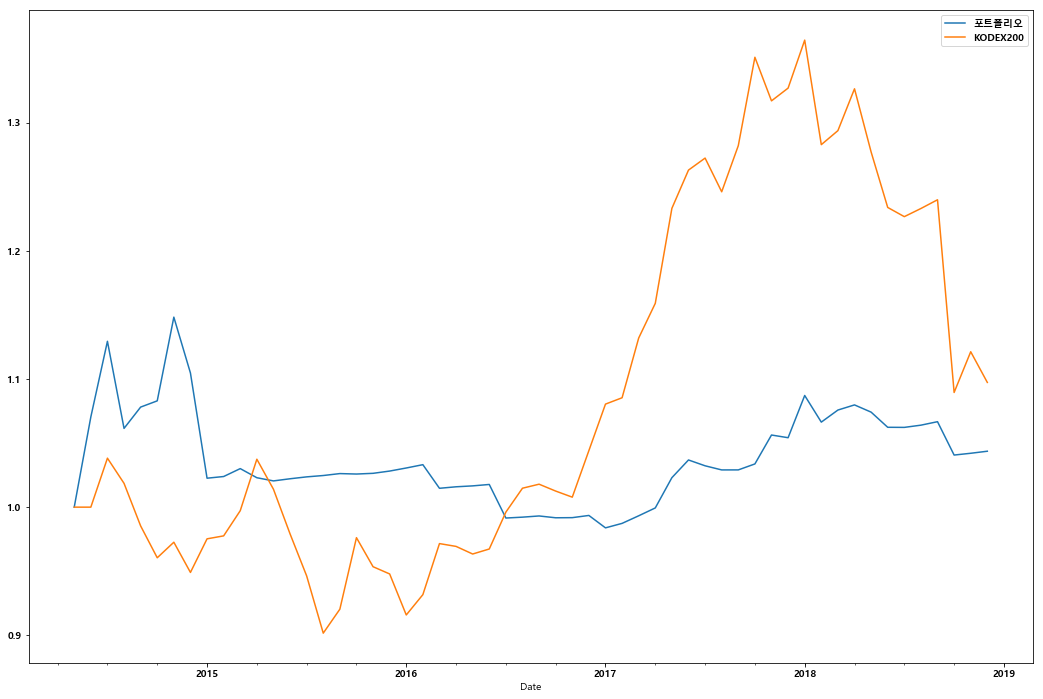

In [23]:
c.columns = ['포트폴리오', 'KODEX200']
c.divide(c.iloc[0]).plot(figsize = (18,12))
plt.show()

In [24]:
c.tail()

,포트폴리오,KODEX200
Date,,
2018-08-31,1.081453,1.221196
2018-09-28,1.084209,1.227942
2018-10-31,1.057747,1.078993
2018-11-30,1.059158,1.110475
2018-12-31,1.060780,1.086761


In [25]:
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락.tail()

Date
2018-08-31    1.16715
2018-09-28    1.16715
2018-10-31    1.16715
2018-11-30    1.16715
2018-12-31    1.16715
Freq: BM, Name: 포트폴리오, dtype: float64

In [26]:
당월하락.tail()

Date
2018-08-31   -0.073424
2018-09-28   -0.071063
2018-10-31   -0.093735
2018-11-30   -0.092527
2018-12-31   -0.091137
Freq: BM, Name: 포트폴리오, dtype: float64

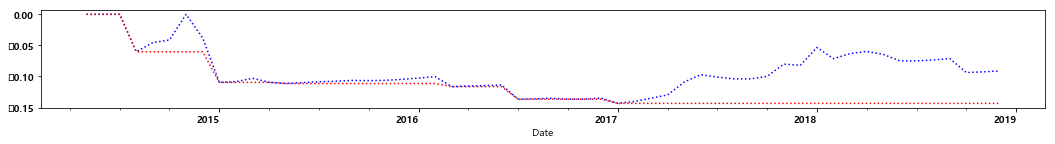

In [27]:
#5. MDD
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), color = 'blue', linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

In [28]:
#6. MDD / CAGR
투자기간 = len(c.index)/12
print("MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("CAGR : "+str(c.포트폴리오[-1]**(1/투자기간)*100-100)[0:4]+"%")

MDD : -14.3%
CAGR : 1.27%


In [29]:
'''
#7. 그래프 파일로 저장하기

for i in 자산군:
    for j in 자료[i].columns:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(1,1,1)
        ax.plot(자료[i][j], label=j)
        ax.plot(자료['국가']["KODEX200"], label ="KODEX200")
        ax.legend(loc="best")
        fig.savefig(j+".png")
        #fig.clf()  # clears the entire current figure 
        plt.close()  # plot에서 close하지 않으면 리소스가 과도하게 소모됨
'''

'\n#7. 그래프 파일로 저장하기\n\nfor i in 자산군:\n    for j in 자료[i].columns:\n        fig = plt.figure(figsize=(12,12))\n        ax = fig.add_subplot(1,1,1)\n        ax.plot(자료[i][j], label=j)\n        ax.plot(자료[\'국가\']["KODEX200"], label ="KODEX200")\n        ax.legend(loc="best")\n        fig.savefig(j+".png")\n        #fig.clf()  # clears the entire current figure \n        plt.close()  # plot에서 close하지 않으면 리소스가 과도하게 소모됨\n'

In [30]:
#7. 그래프 파일로 저장하기
# Plots with different scales

for i in 자산군:
    for j in 자료[i].columns:
        fig, ax1 = plt.subplots(figsize=(12,12))
        
        color = "tab:red"
        ax1.set_ylabel(j,color=color)
        ax1.plot(자료[i][j], label=j, color=color)
        ax1.tick_params(axis="y", labelcolor=color)
        
        # KODEX200 을 기준으로 비교하기
        ax2 = ax1.twinx()
        color = "tab:blue"
        ax2.set_ylabel("KODEX200",color=color)
        ax2.plot(자료['국가']["KODEX200"], label ="KODEX200")
        ax2.tick_params(axis="y", labelcolor=color)
        
        fig.savefig(j+".png")
        #fig.clf()  # clears the entire current figure 
        plt.close()  # plot에서 close하지 않으면 리소스가 과도하게 소모됨